In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

import warnings
warnings.filterwarnings(action='ignore')

2024-05-15 13:00:48.561838: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 13:00:48.679228: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 13:00:49.142346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 13:00:51.034345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
num_of_series = 24
ts_len = 1000
n_past = 10
n_future = 1

## Создание синтетического временного ряда

In [8]:
def sine_ts(n_points, num_of_series, dimension=1, n_periods=4, ampl=10, period_ratio=1/5):
    '''
        Данная функция создает набор из num_of_series временных рядов размера n_points. 
        Временные ряды представляют собой отличающиеся по амплитуде и фазе синусы. 
        Получаемый набор имеет высокую попарную корреляцию.
    '''
    sigma = ampl / 10
    time = np.arange(1, n_points+1)
    series_sines = []
    for i in range(1, num_of_series + 1):
        series = (ampl / 2 * i / 5) * np.sin(2 * np.pi * n_periods * time / n_points + i * 2 * np.pi / num_of_series).reshape(-1, 1)
        series_sines.append(series)
    data = np.hstack(series_sines) + sigma * np.random.randn(n_points, num_of_series)
    column_names = [f'Sine_{i}' for i in range(num_of_series)]
    ts = pd.DataFrame(data, index=time, columns=column_names)
    return ts

In [9]:
ts = sine_ts(ts_len, num_of_series)

In [3]:
def scalling(ts):
    '''
        Данная функция переводит значения набора временных рядов в интервал (-1, 1). 
        Возвращает отмасштабированный ряд и словарь скаллеров для дальнейшего обратного преобразования.
    '''
    scalled_ts = ts
    scalers = {}
    for i in ts.columns:
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(scalled_ts[i].values.reshape(-1,1))
        s_s = np.reshape(s_s,len(s_s))
        scalers['scaler_'+ i] = scaler
        scalled_ts[i] = s_s
    return scalled_ts, scalers

In [4]:
def split_series(series, n_past, n_future):

    '''
        Данная функция по параметрам:
            n_past - количество прошлых значений, используемых для прогноза следующих значений,
            n_future - количество прогнозируемых значений,
        разбивает временной ряд на пары (X, y), для дальнейшего обучения модели. 
        X - вход, предыдущие n_past значений набора временного ряда. 
        y - выход, следующие n_future значений временного ряда.
    '''
    
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
              break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [5]:
def get_split_series(train_ts, test_ts, n_past, num_of_series, n_future=1):
    X_train, y_train = split_series(train_ts.values,n_past, n_future)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_of_series))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], num_of_series))
    X_test, y_test = split_series(test_ts.values,n_past, n_future)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_of_series))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], num_of_series))
    return X_train, y_train, X_test, y_test

In [6]:
def get_e2d2_model(n_past, num_of_series, n_future=1):
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, num_of_series))
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    
    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_of_series))(decoder_l2)
    
    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    return model_e2d2

In [7]:
def train_model(model, X_train, y_train, X_test, y_test, reduce_lr, epochs=10, batch_size=32):
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
    history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),batch_size=batch_size,verbose=0,callbacks=[reduce_lr])
    forecast = model.predict(X_test)
    return forecast

In [8]:
def inverse_scalling(columns, scalers, ts):
    for index, i in enumerate(columns):
        scaler = scalers['scaler_'+i]
        ts[:, :, index] = scaler.inverse_transform(ts[:,:,index])
    return ts

In [9]:
def forecast(ts, n_past, num_of_series, split_point):
    # split_point = int(ts.shape[0] * train_test_ratio)
    train_ts, test_ts = ts[1:split_point], ts[split_point:]

    train, scallers_train = scalling(train_ts)
    test, scallers_test = scalling(test_ts)
    
    X_train, y_train, X_test, y_test = get_split_series(train, test, n_past, num_of_series)

    model_e2d2 = get_e2d2_model(n_past, num_of_series)
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
    pred_e2d2 = train_model(model_e2d2, X_train, y_train, X_test, y_test, reduce_lr)

    pred_e2d2 = inverse_scalling(train_ts.columns, scallers_test, pred_e2d2)
    y_train = inverse_scalling(train_ts.columns, scallers_train, y_train)
    y_test = inverse_scalling(train_ts.columns, scallers_test, y_test)

    pred_e2d2 = pd.DataFrame(pred_e2d2.reshape(ts.shape[0] - split_point - n_past, num_of_series))  
    y_test = pd.DataFrame(y_test.reshape(ts.shape[0] - split_point - n_past, num_of_series)) 

    return pred_e2d2, y_test

In [10]:
def MAPE_MSE_avg(forecast_ts, test_ts, num_of_series):
    sum_mape = 0
    sum_mse = 0
    for i in range(num_of_series):
        ytrue = test_ts.iloc[:, i].values
        yhat = forecast_ts.iloc[:, i].values
        mape = MAPE(ytrue, yhat)
        mse = MSE(ytrue, yhat)
        sum_mape += mape
        sum_mse += mse
    return sum_mape / num_of_series, sum_mse / num_of_series

In [11]:
def accuracy_vs_ts_num(ts):
    num_of_series = ts.shape[1]
    mape_num_of_series = []
    mse_num_of_series = []

    for i in range(1, num_of_series + 1):

        ts_slice = ts.iloc[:, :i]
        forecast_ts, actual_ts = forecast(ts, n_past, num_of_series)
        avg_mape, avg_mse = MAPE_MSE_avg(forecast_ts, actual_ts, num_of_series)
        mape_num_of_series.append(avg_mape)
        mse_num_of_series.append(avg_mse)

    return mape_num_of_series, mse_num_of_series

## Прогнозирования набора высококоррелируемых синусов 

<Axes: >

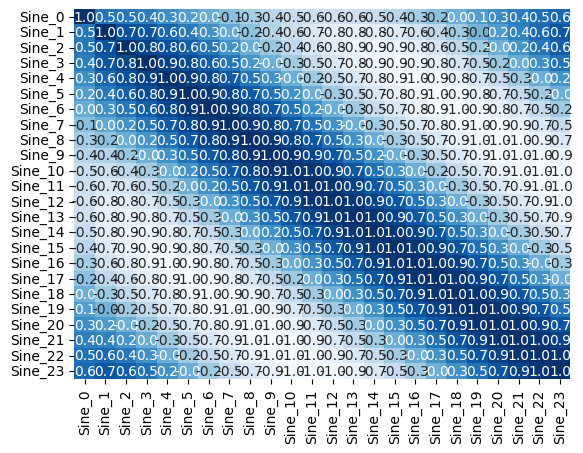

In [14]:
sns.heatmap(ts.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [39]:
forecast_df, actual_df = forecast(ts, n_past, num_of_series)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


In [40]:
Mape_avg, MSE_avg = MAPE_MSE_avg(forecast_df, actual_df, num_of_series)
print(Mape_avg, MSE_avg)

0.9360669767065427 1.3565894317719611


In [41]:
split_point = 700
forecast_df = forecast_df.set_index(forecast_df.index + split_point + 10)

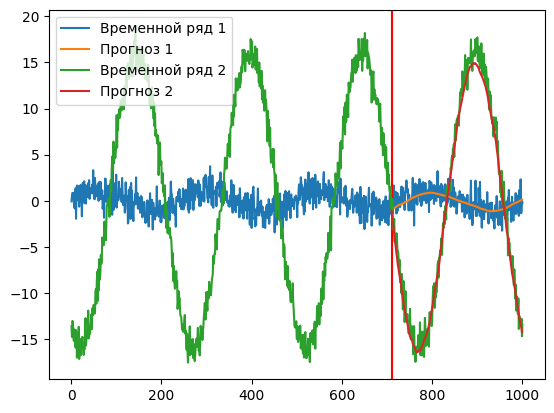

In [43]:
plt.plot(ts.iloc[:, 0], label="Временной ряд 1")
plt.plot(forecast_df.iloc[:, 0], label="Прогноз 1")
plt.axvline(x = split_point + 10, color='r')

plt.plot(ts.iloc[:, 15], label="Временной ряд 2")
plt.plot(forecast_df.iloc[:, 15], label="Прогноз 2")

plt.legend()
plt.savefig("fig_sines")

In [20]:
for i in range(num_of_series):
    ytrue = actual_df.iloc[:, i].values
    yhat = forecast_df.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

0: MAPE = 1.7370819018705694, MSE = 0.9876994777661974
1: MAPE = 1.5949831448723881, MSE = 0.954674567857903
2: MAPE = 1.5196482037767733, MSE = 1.2230434574998796
3: MAPE = 0.8520453862344339, MSE = 0.927286879955102
4: MAPE = 0.9048836393531265, MSE = 1.5357930468283405
5: MAPE = 0.47576716466739405, MSE = 1.4242122612075374
6: MAPE = 0.7817653732011084, MSE = 1.5851764600044465
7: MAPE = 0.5733442332092691, MSE = 1.799773357841726
8: MAPE = 0.2836209939273507, MSE = 1.0860009690444075
9: MAPE = 0.24255783984786028, MSE = 0.8882892343528561
10: MAPE = 0.2868911163543322, MSE = 1.1979212480249384
11: MAPE = 0.2897192642099974, MSE = 1.0173317308282843
12: MAPE = 4.2963494878204775, MSE = 1.3672814773392936
13: MAPE = 0.30603233619305203, MSE = 1.238693540435143
14: MAPE = 0.9111355604773488, MSE = 1.8435476152342265
15: MAPE = 0.33322503041809104, MSE = 1.1549703523651251
16: MAPE = 0.22870952817312273, MSE = 1.1393460930296764
17: MAPE = 0.20280047226618214, MSE = 0.9891437911728448


## Прогнозирование реального набра временных рядов: Цены на электричество.

In [12]:
colnames = ['Time'] + [f'Price{i}' for i in range(24)]

df = pd.read_csv('Погружение временных рядов с высокой волатильностью в метрическое пространство/Данные/GermanSpotPrice.csv', names=colnames, header=None)
df = df.set_index('Time')
df = df.set_index(df.index - 731582)

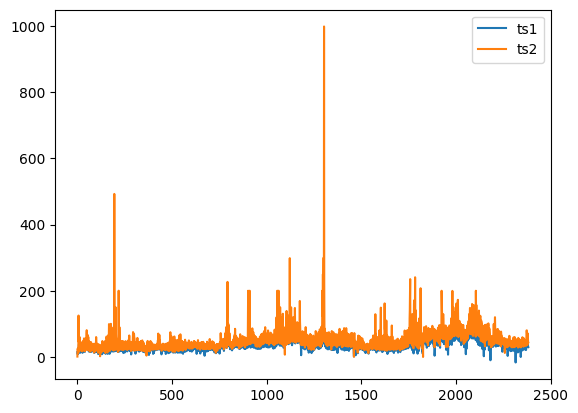

In [13]:
plt.plot(df.iloc[:, 0], label='ts1')
plt.plot(df.iloc[:, 10], label='ts2')
plt.legend()

In [14]:
df = df.iloc[:2000, :]

In [34]:
print(df)

      Price0  Price1  Price2  Price3  Price4  Price5  Price6  Price7  Price8  \
Time                                                                           
0      15.09   11.46    9.58    6.55    4.36    2.09    0.06    0.14    0.00   
1       7.94    4.40    2.05    1.98    2.08    6.08    9.58   15.45   16.63   
2       8.84    7.00    3.51    2.06    2.08    7.04    8.85   16.82   21.81   
3      15.34    8.04    7.05    6.54    4.88    4.09    2.02    7.05   10.55   
4      13.18    8.34    7.54    6.59    6.77    5.51    1.04    2.00    4.54   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1995   62.92   54.57   45.08   43.04   39.57   49.32   63.95   80.00   86.90   
1996   59.93   45.93   40.05   30.07   36.57   45.93   69.52   92.68   87.75   
1997   57.99   46.04   32.39   29.98   18.06   33.54   55.13   79.08   86.01   
1998   64.49   60.03   49.02   41.10   44.96   38.09   49.03   63.74   68.47   
1999   66.28   62.28   43.06   33.91   3

<Axes: >

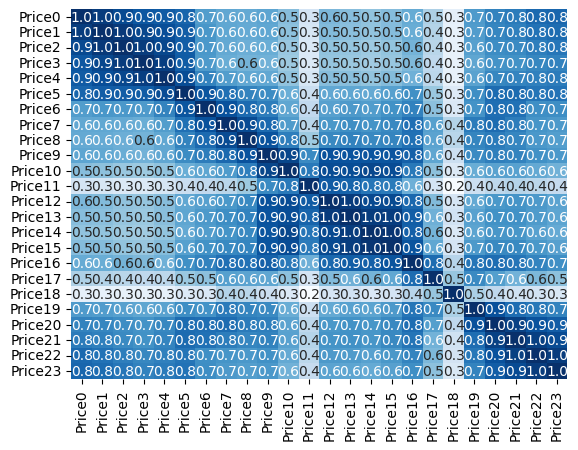

In [35]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [106]:
num_of_series = df.shape[1]

In [37]:
num_of_series = df.shape[1]

forecast_df, actual_df = forecast(df, n_past, num_of_series, train_test_ratio=0.99)

train_test_ratio = 0.99
split_point = int(df.shape[0] * train_test_ratio)
forecast_df = forecast_df.set_index(forecast_df.index + split_point + 10)

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

for i in range(num_of_series):
    ytrue = actual_df.iloc[:, i].values
    yhat = forecast_df.iloc[:, i].values
    mae = MAE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAE = {mae}, MSE = {mse}")

plt.plot(df.iloc[1980:, 0], label="Временной ряд 1")
plt.plot(forecast_df.iloc[:, 0], label="Прогноз 1")
plt.axvline(x = split_point + 10, color='r')
plt.legend()

plt.plot(df.iloc[1980:, 7], label="Временной ряд 2")
plt.plot(forecast_df.iloc[:, 7], label="Прогноз 2")
plt.axvline(x = split_point + 10, color='r')
plt.legend()

Mape_avg, MSE_avg = MAPE_MSE_avg(forecast_df, actual_df, num_of_series)
print(Mape_avg, MSE_avg)

forecasted_size = forecast_df.shape[0]
df_size = forecast_df.shape[0]

for i in range(forecasted_size):
    mae_ = MAE(forecast_df.iloc[i, :].values, df.iloc[df_size - forecasted_size + i, :].values)
    print(f'MAE прогноза {i + 1} значения временного ряда: {mae_}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


In [38]:
train_test_ratio = 0.99
split_point = int(df.shape[0] * train_test_ratio)
forecast_df = forecast_df.set_index(forecast_df.index + split_point + 10)

In [39]:
forecast_df.head()
forecast_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1995,61.705910,50.521015,44.877930,36.009708,32.960087,40.567890,45.561913,63.775566,73.135300,120.618416,...,92.233231,77.369408,70.993973,69.037697,69.519661,71.903831,67.841461,66.081436,67.183006,60.548843
1996,61.920658,51.082520,45.628487,36.804497,33.592113,40.673817,44.232784,66.169884,74.843918,124.398605,...,95.163010,79.968071,71.612831,70.312637,70.868607,72.542549,68.134148,65.994492,67.209824,60.391773
1997,62.100857,51.090816,45.628666,36.928829,33.808456,40.500431,43.946804,65.145996,73.030098,120.483353,...,93.289726,77.461586,70.733543,68.921036,69.595535,72.135109,67.888817,66.213646,67.547729,60.726818
1998,62.441147,51.180862,45.458771,36.728703,33.583973,40.418896,46.155231,66.670326,74.009224,121.400391,...,94.595589,78.526375,72.298996,69.574173,69.564003,72.197906,68.186096,67.085045,68.578682,61.264721
1999,62.476322,51.151939,45.434696,36.752621,33.320210,39.705505,44.014385,64.795982,72.192680,118.522690,...,92.827049,76.869987,70.919586,68.759293,69.195511,71.941765,67.554253,66.931976,68.951851,61.468334


In [40]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

for i in range(num_of_series):
    ytrue = actual_df.iloc[:, i].values
    yhat = forecast_df.iloc[:, i].values
    mae = MAE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAE = {mae}, MSE = {mse}")

0: MAE = 4.111129928588865, MSE = 29.921611118252116
1: MAE = 7.43919970703125, MSE = 69.67422639171335
2: MAE = 5.923694458007812, MSE = 60.4643573198166
3: MAE = 7.541701721191407, MSE = 65.69272781903683
4: MAE = 9.4780281829834, MSE = 105.90038647116917
5: MAE = 8.909042388916015, MSE = 104.69204610448222
6: MAE = 17.84581946563721, MSE = 372.0218993025536
7: MAE = 21.63138265991211, MSE = 582.3398338414709
8: MAE = 17.021531524658204, MSE = 348.4450391967885
9: MAE = 35.10696844482421, MSE = 1586.6268747736312
10: MAE = 31.01795562744141, MSE = 1260.7878864695645
11: MAE = 33.741877441406245, MSE = 1433.2015009103984
12: MAE = 20.842807373046874, MSE = 583.5202239268071
13: MAE = 21.85983737182617, MSE = 596.8664748566811
14: MAE = 22.99419677734375, MSE = 673.7161137560187
15: MAE = 15.133491943359378, MSE = 346.81746100432156
16: MAE = 12.815003662109373, MSE = 251.16030422577984
17: MAE = 10.40459552001953, MSE = 152.79568624854923
18: MAE = 8.352925598144529, MSE = 83.70716615

In [41]:
variance = df.var()
print(variance)

Price0      132.475757
Price1      122.244656
Price2      112.782665
Price3      104.090473
Price4      101.699753
Price5      127.632979
Price6      246.315643
Price7      664.852943
Price8      856.012822
Price9      952.303951
Price10    1425.047360
Price11    4188.434428
Price12    1023.208060
Price13     965.616008
Price14     951.179269
Price15     756.366439
Price16     586.364864
Price17    1528.567488
Price18    5806.839914
Price19     612.830980
Price20     330.981572
Price21     208.363856
Price22     179.068798
Price23     118.412207
dtype: float64


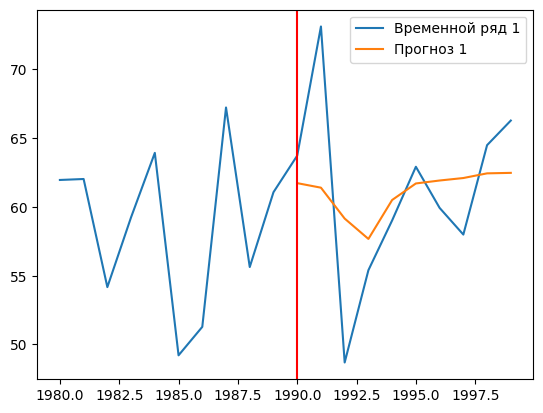

In [42]:
plt.plot(df.iloc[1980:, 0], label="Временной ряд 1")
plt.plot(forecast_df.iloc[:, 0], label="Прогноз 1")
plt.axvline(x = split_point + 10, color='r')
plt.legend()

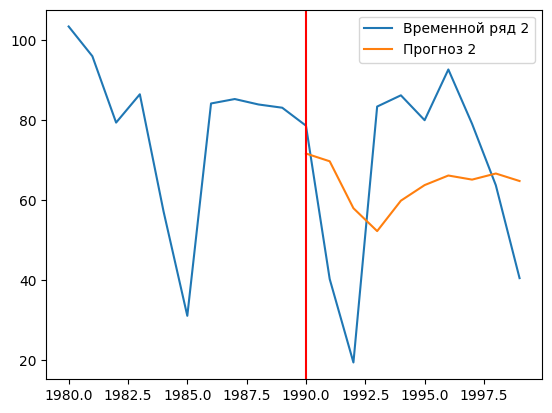

In [43]:
plt.plot(df.iloc[1980:, 7], label="Временной ряд 2")
plt.plot(forecast_df.iloc[:, 7], label="Прогноз 2")
plt.axvline(x = split_point + 10, color='r')
plt.legend()

In [44]:
Mape_avg, MSE_avg = MAPE_MSE_avg(forecast_df, actual_df, num_of_series)
print(Mape_avg, MSE_avg)

14.393613595644632 377.0201813007946


### Зависимость ошибки от порядка прогноза

In [45]:
print(forecast_df)

             0          1          2          3          4          5   \
1990  61.729168  50.938614  45.204739  36.108620  33.502075  40.215687   
1991  61.399506  50.151302  44.685032  35.711704  32.843143  39.453316   
1992  59.152493  47.280655  42.016613  32.620602  28.634939  33.730667   
1993  57.674049  45.778450  39.933762  31.234180  27.387100  33.646950   
1994  60.505295  49.256062  43.370762  34.853855  31.668982  39.458790   
1995  61.705910  50.521015  44.877930  36.009708  32.960087  40.567890   
1996  61.920658  51.082520  45.628487  36.804497  33.592113  40.673817   
1997  62.100857  51.090816  45.628666  36.928829  33.808456  40.500431   
1998  62.441147  51.180862  45.458771  36.728703  33.583973  40.418896   
1999  62.476322  51.151939  45.434696  36.752621  33.320210  39.705505   

             6          7          8           9   ...          14         15  \
1990  43.733047  71.665482  77.594757  132.871445  ...  103.815979  87.556183   
1991  43.158119  69.728

In [47]:
forecasted_size = forecast_df.shape[0]
df_size = forecast_df.shape[0]

for i in range(forecasted_size):
    mae_ = MAE(forecast_df.iloc[i, :].values, df.iloc[df_size - forecasted_size + i, :].values)
    print(f'MAE прогноза {i + 1} значения временного ряда: {mae_}')

MAE прогноза 1 значения временного ряда: 69.87933627446493
MAE прогноза 2 значения временного ряда: 55.70210200627645
MAE прогноза 3 значения временного ряда: 52.88400501887003
MAE прогноза 4 значения временного ряда: 47.57884441375732
MAE прогноза 5 значения временного ряда: 55.58679838498434
MAE прогноза 6 значения временного ряда: 56.62902153015136
MAE прогноза 7 значения временного ряда: 111.59851870854696
MAE прогноза 8 значения временного ряда: 32.983068065643316
MAE прогноза 9 значения временного ряда: 35.31578387578329
MAE прогноза 10 значения временного ряда: 28.636514307657876


In [102]:
def detect_outliers(data):
    Q1 = np.percentile(data, 15)
    Q3 = np.percentile(data, 85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = np.where((data < lower_bound) | (data > upper_bound))
    return outliers

# Найдем выбросы во временном ряде
outliers_indices = detect_outliers(df.iloc[:, 23].copy())

# Выведем индексы выбросов и их значения
print("Индексы выбросов:", outliers_indices)

Индексы выбросов: (array([], dtype=int64),)


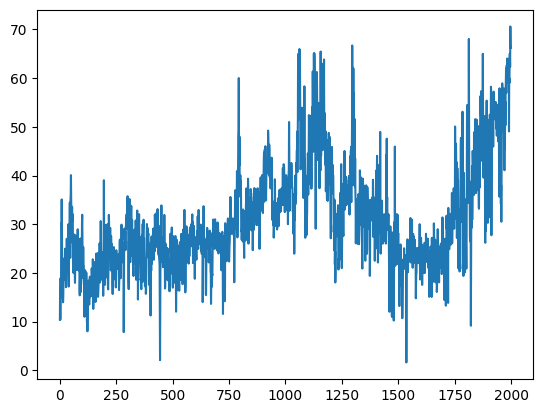

In [103]:
plt.plot(df.iloc[:, 23])

### Определим количество временных рядов из набора, которые разумно прогнозировать.

In [72]:
number_of_ts_vs_MSE = []
number_of_ts_vs_MAE = []
shuffled_column_names = []
num_of_shuffles = 10

In [73]:
for i in range(num_of_shuffles):
    shuffled_df = df.sample(frac=1, axis=1)
    shuffled_column_names.append(shuffled_df.columns)
    mae, mse = accuracy_vs_ts_num(shuffled_df)
    number_of_ts_vs_MSE.append(mse)
    number_of_ts_vs_MAE.append(mae)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [74]:
number_of_ts_forecasting = [i for i in range(1, 25)]

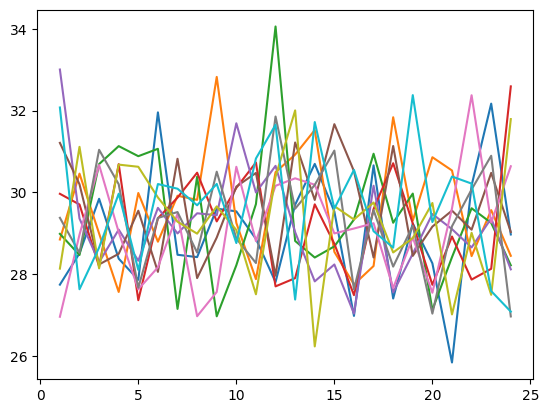

In [75]:
for x in number_of_ts_vs_MAE:
    plt.plot(number_of_ts_forecasting, x)

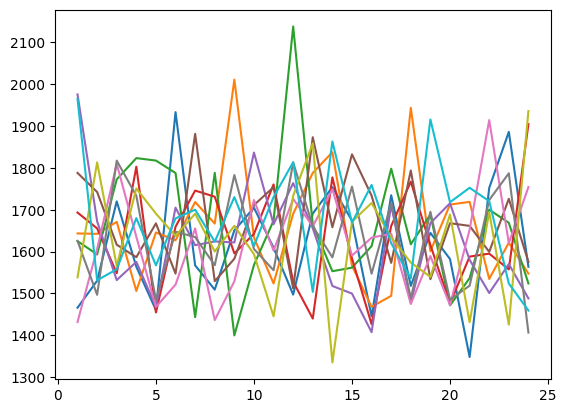

In [76]:
for x in number_of_ts_vs_MSE:
    plt.plot(number_of_ts_forecasting, x)

In [77]:
difference = []

for i in range(num_of_shuffles):
    difference.append([0])
    for j in range(1, 24):
        difference[i].append(number_of_ts_vs_MAE[i][j] - number_of_ts_vs_MAE[i][j - 1])

In [84]:
keys = list(df.columns)
my_dict = {key: [] for key in keys}

In [85]:
for i in range(10):
    for j in range(24):
        if difference[i][j] != 0:
            my_dict[shuffled_column_names[i][j]].append(difference[i][j])

In [86]:
print(my_dict)

{'Price0': [-1.0561203735133944, 2.614576764936885, -1.6868270388122042, 2.1031929760244914, -0.7606915255261875, 0.3335680591014629, 1.7036621211480494, 2.5204256121749964, 3.4295760744958272, 1.1129939607765635], 'Price1': [0.7661133186963411, -1.3741925303786076, 1.248077807653008, 2.001938280063669, 0.7104230999843573, -1.4043109984718605, 0.5933904566995558, -2.253544538899238, -2.9709353481742973, 0.9462308233507954], 'Price2': [-1.4633531386165721, -2.9771993266618324, 0.43919589231612477, 2.4986914742196724, 0.6505218599338036, 3.2557567979012774, 2.060764792270078, 0.1435106566807356, -0.5783778967992959, 1.0188327747379873], 'Price3': [-0.9732614483178033, -1.1905358719367598, 4.341326941565647, -1.2551250437109225, -0.4481368964506167, 1.053049137347294, 0.18292606616312312, 0.5813141999993867, 0.857774218076635, -2.626843184369605], 'Price4': [-2.4241800298200893, 0.4284932700363129, 1.4956911646069777, 0.5063643406714782, 0.7968447798094545, 2.764654221196473, -1.351273301

In [87]:
mean_values = {key: np.mean(value) for key, value in my_dict.items()}

In [88]:
print(mean_values)

{'Price0': 1.031435663080649, 'Price1': -0.17368096294762764, 'Price2': 0.5048343885981978, 'Price3': 0.0522488118366379, 'Price4': 0.3751033096714895, 'Price5': -0.5369105478454486, 'Price6': -0.7251592746072415, 'Price7': 0.3953290439642608, 'Price8': 0.28196740176283364, 'Price9': 0.005169369696608328, 'Price10': -0.5068118424465946, 'Price11': 0.2139766239139295, 'Price12': 0.13588376264079755, 'Price13': 0.2697776706351287, 'Price14': 0.4274514203365598, 'Price15': 0.7003792236710737, 'Price16': -1.0151690475163855, 'Price17': -0.9602855682655833, 'Price18': 0.7841289678664765, 'Price19': -1.2159287914634374, 'Price20': -0.00046179247940472126, 'Price21': 0.7748561581197061, 'Price22': -1.0979370623244251, 'Price23': -0.3616845030157399}


In [89]:
avg_mae_vs_num_ts = []

In [90]:
for i in range(24):
    sum_ = 0
    for j in range(10):
        sum_ += number_of_ts_vs_MAE[j][i]
    avg_mae_vs_num_ts.append(sum_ / 10)

In [91]:
print(avg_mae_vs_num_ts)

[29.631548506275276, 29.294388425285653, 29.276779932034277, 29.523853819467906, 28.801952076719097, 29.649165405910043, 29.361610100958593, 29.068061738780074, 29.49693265103022, 29.63000643047028, 29.308948180699332, 30.27339762926721, 29.692337222080944, 29.63083121075751, 29.47025025238379, 28.575086610763314, 29.55927063883335, 29.093789249150188, 29.406014947228005, 28.623619375516235, 28.85649665312087, 29.55171846063838, 29.421392820914853, 29.187155035770036]


(20.0, 40.0)

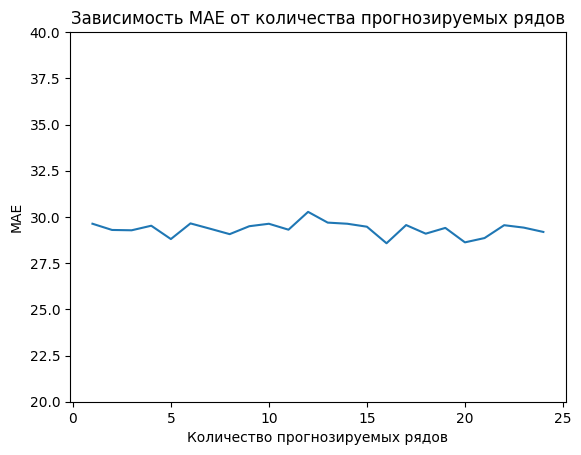

In [95]:
plt.plot(number_of_ts_forecasting, avg_mae_vs_num_ts)
plt.xlabel("Количество прогнозируемых рядов")
plt.ylabel("MAE")
plt.title("Зависимость MAE от количества прогнозируемых рядов")
plt.ylim(20, 40)

### Нормальные ряды

In [15]:
for i in range(7, 21):
    del df[f'Price{i}']

In [16]:
print(df)

      Price0  Price1  Price2  Price3  Price4  Price5  Price6  Price21  \
Time                                                                    
0      15.09   11.46    9.58    6.55    4.36    2.09    0.06    11.57   
1       7.94    4.40    2.05    1.98    2.08    6.08    9.58    19.93   
2       8.84    7.00    3.51    2.06    2.08    7.04    8.85    13.21   
3      15.34    8.04    7.05    6.54    4.88    4.09    2.02    20.14   
4      13.18    8.34    7.54    6.59    6.77    5.51    1.04    16.59   
...      ...     ...     ...     ...     ...     ...     ...      ...   
1995   62.92   54.57   45.08   43.04   39.57   49.32   63.95    73.66   
1996   59.93   45.93   40.05   30.07   36.57   45.93   69.52    69.54   
1997   57.99   46.04   32.39   29.98   18.06   33.54   55.13    75.93   
1998   64.49   60.03   49.02   41.10   44.96   38.09   49.03    69.91   
1999   66.28   62.28   43.06   33.91   30.07   22.43   20.16    67.95   

      Price22  Price23  
Time                    


In [17]:
for i in range(3):
    df = df.rename(columns={f'Price{21 + i}': f'Price{7 + i}'})

In [18]:
print(df)

      Price0  Price1  Price2  Price3  Price4  Price5  Price6  Price7  Price8  \
Time                                                                           
0      15.09   11.46    9.58    6.55    4.36    2.09    0.06   11.57   14.81   
1       7.94    4.40    2.05    1.98    2.08    6.08    9.58   19.93   23.98   
2       8.84    7.00    3.51    2.06    2.08    7.04    8.85   13.21   13.93   
3      15.34    8.04    7.05    6.54    4.88    4.09    2.02   20.14   23.88   
4      13.18    8.34    7.54    6.59    6.77    5.51    1.04   16.59   24.73   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1995   62.92   54.57   45.08   43.04   39.57   49.32   63.95   73.66   75.71   
1996   59.93   45.93   40.05   30.07   36.57   45.93   69.52   69.54   73.41   
1997   57.99   46.04   32.39   29.98   18.06   33.54   55.13   75.93   79.03   
1998   64.49   60.03   49.02   41.10   44.96   38.09   49.03   69.91   76.10   
1999   66.28   62.28   43.06   33.91   3

<Axes: >

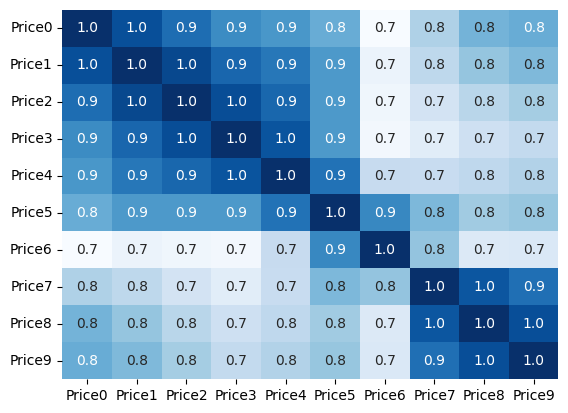

In [19]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

## `Зависимость MAPE от горизонта прогноза`

In [25]:
num_of_series = df.shape[1]
series_size = df.shape[0]
L = 10
n_past = 10

### `Проведем прогнозы с шириной окна от 1 до 20. Каждый из них проведем по несколько раз и усредним точность прогноза. Далее, по правилу сломанной трости выберем оптимальную ширину окна.`

In [32]:
MAPE_vs_forecast_horizon = []
MSE_vs_forecast_horizon = []

for i in range(1, 21):
    MAPE_array_for_each = []
    MSE_array_for_each = []
    for j in range(5):
        split_point = series_size - i - L
        forecast_df, actual_df = forecast(df, n_past, num_of_series, split_point)
        forecast_df = forecast_df.set_index(forecast_df.index + split_point + 10)
        MAPE_avg, MSE_avg = MAPE_MSE_avg(forecast_df, actual_df, num_of_series)
        MAPE_array_for_each.append(MAPE_avg)
        MSE_array_for_each.append(MSE_avg)
    MAPE_vs_forecast_horizon.append(MAPE_array_for_each)
    MSE_vs_forecast_horizon.append(MSE_array_for_each)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [39]:
avg_MAPE_fh = [np.array(arr).mean() for arr in MAPE_vs_forecast_horizon] # усреднение точности по нескольким повторениям одного и того же прогноза
quadratic_dev = [np.array((np.array(arr) - np.array(arr).mean()) ** 2).mean() for arr in MAPE_vs_forecast_horizon] # среднеквадратичное отклонение

In [40]:
print(quadratic_dev) # среднеквадратичное отклонение

[0.00011035637021030639, 5.94807077311138e-05, 1.1234146024435012e-05, 3.571323413649979e-05, 4.530861193345113e-06, 4.779553581859589e-06, 1.980954714283711e-06, 2.7513247518226712e-05, 5.6100374618195936e-05, 1.3926165810727526e-05, 6.323250874327804e-05, 1.07282896547383e-05, 7.6260173710949735e-06, 9.272751381255794e-06, 6.906751981283242e-06, 1.7118159291865266e-05, 4.220228814012351e-06, 2.7654973585957906e-05, 1.7603197382006207e-05, 1.0727868330598943e-05]


Text(0.5, 1.0, 'Зависимость MAPE от горизонта прогноза LSTM.')

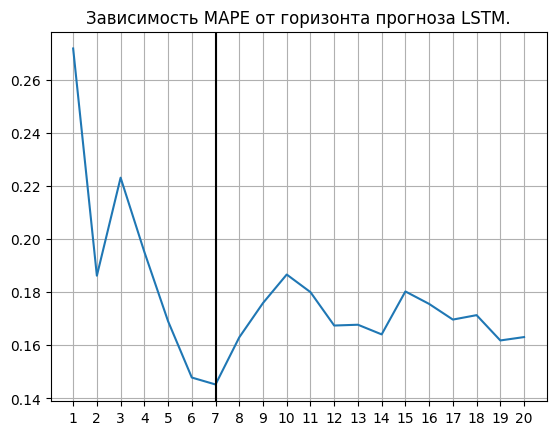

In [52]:
plt.plot([i for i in range(1, 21)], avg_MAPE_fh)
plt.grid ( True )
plt.xticks([i for i in range(1, 21)])
plt.axvline(x = 7, color='black')
plt.title("Зависимость MAPE от горизонта прогноза LSTM.")

`Таким образом, по правилу сломанной трости, получаем, что лучший горизонт прогнозирования - 7 дней.`

## `Выполнение прогноза с наилучшим горизонтом прогноза.`

In [44]:
split_point = series_size - 7 - L
forecast_df, actual_df = forecast(df, n_past, num_of_series, split_point)
forecast_df = forecast_df.set_index(forecast_df.index + split_point + 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [45]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

for i in range(num_of_series):
    ytrue = actual_df.iloc[:, i].values
    yhat = forecast_df.iloc[:, i].values
    mape = MAPE(ytrue, yhat)
    mse = MSE(ytrue, yhat)
    print(f"{i}: MAPE = {mape}, MSE = {mse}")

0: MAPE = 0.04744064443308061, MSE = 11.808445276910735
1: MAPE = 0.10710380329387616, MSE = 40.641235355610696
2: MAPE = 0.11339595560197853, MSE = 38.58111439204784
3: MAPE = 0.17223499474445886, MSE = 42.651782992507286
4: MAPE = 0.27492343125705593, MSE = 89.34734820589749
5: MAPE = 0.25252670244729397, MSE = 99.78946193324656
6: MAPE = 0.3000385758605017, MSE = 167.18496171970898
7: MAPE = 0.05292459451190997, MSE = 30.254061082733074
8: MAPE = 0.09091815407621066, MSE = 52.58602446074463
9: MAPE = 0.05065675180633729, MSE = 18.59267814705155


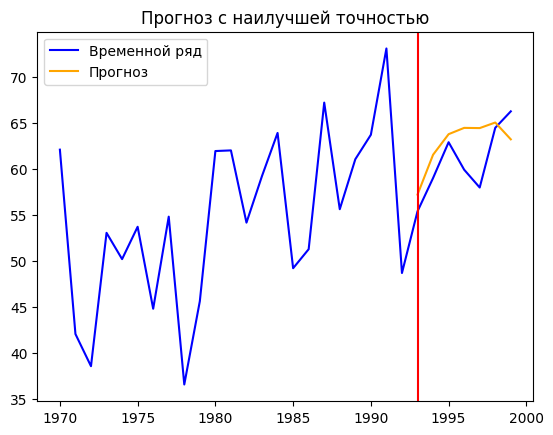

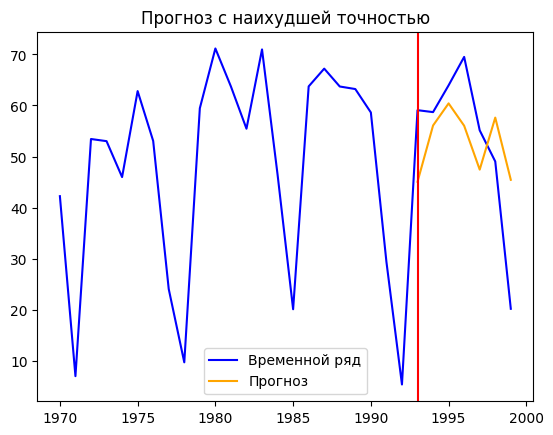

In [54]:
plt.plot(df.iloc[1970:, 0], label="Временной ряд", color='b')
plt.plot(forecast_df.iloc[:, 0], label="Прогноз", color='orange')
plt.axvline(x = split_point + 10, color='r')
plt.title("Прогноз с наилучшей точностью")
plt.legend()
plt.show()

plt.plot(df.iloc[1970:, 6], label="Временной ряд", color='b')
plt.plot(forecast_df.iloc[:, 6], label="Прогноз", color='orange')
plt.axvline(x = split_point + 10, color='r')
plt.title("Прогноз с наихудшей точностью")
plt.legend()
plt.show()

In [47]:
Mape_avg, MSE_avg = MAPE_MSE_avg(forecast_df, actual_df, num_of_series)
print(Mape_avg, MSE_avg)

0.14621636080327036 59.14371135664588


In [48]:
forecasted_size = forecast_df.shape[0]
df_size = df.shape[0]

for i in range(forecasted_size):
    mae_ = MAE(forecast_df.iloc[i, :].values, df.iloc[df_size - forecasted_size + i, :].values)
    print(f'MAE прогноза {i + 1} значения временного ряда: {mae_}')

MAE прогноза 1 значения временного ряда: 5.870044578552246
MAE прогноза 2 значения временного ряда: 4.541328247070314
MAE прогноза 3 значения временного ряда: 2.3743677673339834
MAE прогноза 4 значения временного ряда: 5.177381713867186
MAE прогноза 5 значения временного ряда: 10.597092910766602
MAE прогноза 6 значения временного ряда: 4.6941137084960936
MAE прогноза 7 значения временного ряда: 7.9982356872558595


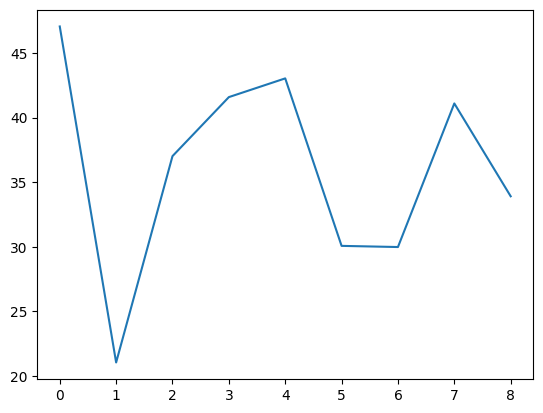

In [56]:
plt.plot(df.iloc[1991:2000, 3].values, label=f"Реальный временной ряд {3}")